In [223]:
import numpy as np
import math

import os
from os.path import expanduser
home = expanduser("~")
os.environ["OMP_NUM_THREADS"] = "1"
#import warnings
#warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src')
from importlib import reload

#astropy
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel,Gaussian2DKernel
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.stats import mad_std,sigma_clipped_stats
from photutils import detection

#scipy
from scipy.interpolate import pchip
from scipy import ndimage
from scipy.signal import find_peaks
from scipy.optimize import minimize,differential_evolution,basinhopping,dual_annealing

#matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display


# NGC 6328 redshift

In [3]:
z=0.014313
arc_to_kpc=(cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
arc_to_kpc

<Quantity 0.29495281 kpc / arcsec>

# Import Data

In [5]:
import utils
cubefolder='../data/NGC6328/cubes/'
cloudsfolder='../data/NGC6328/clouds/'
datafolder='../data/NGC6328/other/'

## Cubes

In [12]:
reload(utils)

cube21_file=cubefolder+'NGC6328_CO_selfcal_20km_natural_pbcor.fits'
ucube21_file=cubefolder+'NGC6328_CO_selfcal_20km_natural.fits'
z=0.014313
CO21,CO21_total=utils.load_fits_cube(cube_file=cube21_file,ucube_file=ucube21_file,pbfile=None,
                    drop={'x':2.6,'y':4.9,'v':460},z=z,sigma=5,
                     beam=[0.296,0.220,38.624],zaxis='freq',restFreq=230.538e9,
                    debug=False,nosignalregions = [{'x0':300,'y0':600,'dx':200,'dy':500},{'x0':1200,'y0':600,'dx':200,'dy':500}])
rms=CO21.attrs['rms']

Original Data Corrected Cube shape (123, 1680, 1680)
Original Data UnCorrected Cube shape (123, 1680, 1680)
RMS Noise in area {'x0': 300, 'y0': 600, 'dx': 200, 'dy': 500} 0.0002467646215950085
RMS Noise in area {'x0': 1200, 'y0': 600, 'dx': 200, 'dy': 500} 0.00024745194844498736
Mean RMS:  0.00024710828501999795


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<Quantity 0.00499884 kpc2 / beam>

<Quantity 7.82974432e-05 1 / pix2>

## HI

In [6]:
macc_HI_Vrot=np.loadtxt(datafolder+'macc_HI_Vrot.csv',delimiter=',')
vc_HI_Vrot=np.loadtxt(datafolder+'vc_HI_Vrot.csv',delimiter=',')
V_sys=4274

min_to_kpc=(cosmo.angular_diameter_distance(0.014313)/u.radian).to(u.kpc/u.arcmin)
sec_to_kpc=(cosmo.angular_diameter_distance(0.014313)/u.radian).to(u.kpc/u.arcsec)

R_macc_HI=(macc_HI_Vrot[:,0])*u.arcmin*min_to_kpc
V_macc_HI=macc_HI_Vrot[:,1]-V_sys

R_vc_HI=(vc_HI_Vrot[:,0])*u.arcsec*sec_to_kpc
V_vc_HI=vc_HI_Vrot[:,1]-V_sys-20

Rm=np.abs(R_macc_HI.value)
Rvc=np.abs(R_vc_HI.value)
Vm_20=V_macc_HI/np.sin(np.radians(20))
Vvc_20=V_vc_HI/np.sin(np.radians(20))
HI_sigma=40
Rc=20

Rmf=Rm[(Rm>21)&(Rm<36)]
Vmf=np.abs(Vm_20[(Rm>21)&(Rm<36)])
Rvcf=Rvc[(Rvc>21)&(Rvc<36)]
Vvcf=np.abs(Vvc_20[(Rvc>21)&(Rvc<36)])

# Source detection progress

In [167]:
!rsync -uvrP mixpap@195.251.202.114:/home/mixpap/astro/ARC/notebooks/cube_fitter/*.npy ../data/NGC6328/clouds
!rsync -uvrP mixpap@195.251.202.114:/home/mixpap/astro/ARC/notebooks/cube_fitter/3ddetM.out .

receiving incremental file list
A3d.npy
          2,456 100%    2.34MB/s    0:00:00 (xfr#1, to-chk=18/19)
V3d.npy
          2,456 100%    2.34MB/s    0:00:00 (xfr#2, to-chk=12/19)
X3d.npy
          2,456 100%    2.34MB/s    0:00:00 (xfr#3, to-chk=10/19)
Y3d.npy
          2,456 100%    2.34MB/s    0:00:00 (xfr#4, to-chk=8/19)
a3d.npy
          2,456 100%    1.17MB/s    0:00:00 (xfr#5, to-chk=7/19)
b3d.npy
          2,456 100%    1.17MB/s    0:00:00 (xfr#6, to-chk=6/19)
c3d.npy
          2,456 100%  799.48kB/s    0:00:00 (xfr#7, to-chk=5/19)
sv3d.npy
          2,456 100%  799.48kB/s    0:00:00 (xfr#8, to-chk=4/19)

sent 368 bytes  received 9,309 bytes  6,451.33 bytes/sec
total size is 5,143,290  speedup is 531.50
receiving incremental file list
3ddetM.out
         64,429 100%   61.44MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 595 bytes  received 1,187 bytes  1,188.00 bytes/sec
total size is 64,429  speedup is 36.16


In [168]:
finished=[]
with open("3ddetM.out", "r") as fp:
    lines = [line for line in fp if 'Found' in line]
    for line in lines:
        finished.append(line.split()[4])

In [169]:
tried=[]
with open("3ddetM.out", "r") as fp:
    lines = [line for line in fp if 'Trying' in line]
    for line in lines:
        #print(int(line.split()[11]),int(line.split()[11])<300)
        if int(line.split()[11])<300:
            tried.append(line.split()[3])

In [246]:

X3d=np.array([])
Y3d=np.array([])
A3d=np.array([])
V3d=np.array([])
a3d=np.array([])
b3d=np.array([])
c3d=np.array([])
Sv3d=np.array([])
with open("3ddetM.out", "r") as fp:
    lines = [line for line in fp if 'Results' in line]
    for line in lines:
        A3d=np.append(A3d,float(line.split()[4]))
        X3d=np.append(X3d,float(line.split()[5][3:-1]))
        Y3d=np.append(Y3d,float(line.split()[6][3:]))
        V3d=np.append(V3d,float(line.split()[7][3:]))
        a3d=np.append(a3d,float(line.split()[8][3:-1]))
        b3d=np.append(b3d,float(line.split()[9][3:-1]))
        c3d=np.append(c3d,float(line.split()[10][3:-1]))
        Sv3d=np.append(Sv3d,float(line.split()[11][3:]))
        #print(float(line.split()[8][3:-1]))
        # if int(line.split()[11])<300:
        #     tried.append(line.split()[3])
print(A3d.shape)       
R3d= np.sqrt(X3d**2+Y3d**2)
PHI3d=np.arctan2(Y3d,X3d)

(254,)


In [247]:
Xcloud=np.load(cloudsfolder+'X3d.npy')
Ycloud=np.load(cloudsfolder+'Y3d.npy')
Vcloud=np.load(cloudsfolder+'V3d.npy')
acloud=np.load(cloudsfolder+'a3d.npy')
bcloud=np.load(cloudsfolder+'b3d.npy')
ccloud=np.load(cloudsfolder+'c3d.npy')
Svcloud=np.load(cloudsfolder+'sv3d.npy')
Acloud=np.load(cloudsfolder+'A3d.npy')

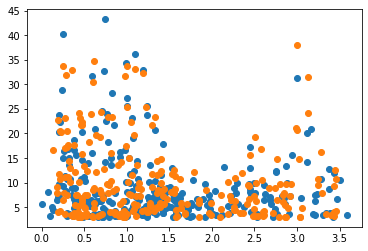

In [248]:
plt.plot(np.sqrt(Xcloud**2+Ycloud**2),Acloud/rms,'o')
plt.plot(R3d,A3d,'o')

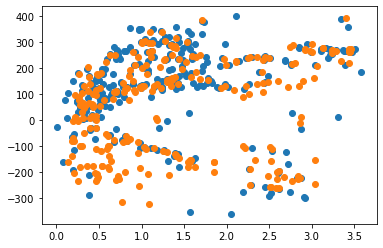

In [249]:
plt.plot(np.sqrt(Xcloud**2+Ycloud**2),Vcloud,'o')
plt.plot(R3d,V3d,'o')

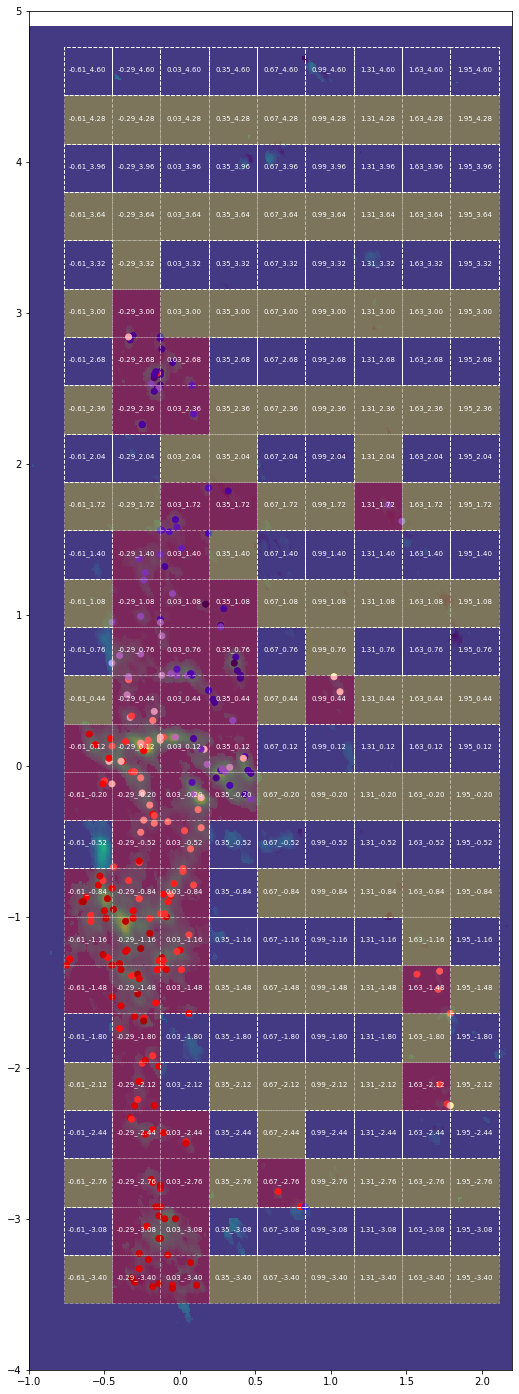

In [218]:
Rg=0.4
xgrid=np.arange(-0.8,1,2*Rg)
ygrid=np.arange(-4.,3.2,2*Rg)

Rg=0.5
xgrid=[-0.2]
ygrid=[-3.1]

Rg=0.12
xgrid=np.arange(-0.8,1,2*Rg)
ygrid=np.arange(-4.,3.2,2*Rg)

Rg=0.16
xgrid=np.arange(-0.61,2,2*Rg)
ygrid=np.arange(-3.4,4.8,2*Rg)
# Rg=0.06
# xgrid=np.arange(-0.5,-0.3,2*Rg)
# ygrid=np.arange(-1,0,2*Rg)

# Rg=0.16
# xgrid=np.arange(-0.61,2,2*Rg)
# ygrid=np.arange(-3.4,4.8,2*Rg)
    
fig,ax=plt.subplots(1,1,figsize=(20,25))
ax.pcolormesh(CO21.x,CO21.y,np.nansum(CO21['cube'],axis=0),shading='auto')
ax.set(aspect=1,xlim=[-1,2.2],ylim=[-4,5])
for xx in xgrid:
    for yy in ygrid:
        name=f"{xx:.2f}_{yy:.2f}"
        ax.text(xx,yy,name,color='white',fontsize=7,horizontalalignment='center')
        if name in finished:
            #print(name)
            ax.add_patch(plt.Rectangle((xx-Rg, yy-Rg), 2*Rg, 2*Rg,fc='red',ls="--",color='white',alpha=0.3))#, ls="--", ec="c", fc="None",transform=ax.transAxes))
        elif name in tried:
            ax.add_patch(plt.Rectangle((xx-Rg, yy-Rg), 2*Rg, 2*Rg,fc='yellow',ls="--",color='white',alpha=0.3))#, ls="--", ec="c", fc="None",transform=ax.transAxes))
        else:
            ax.add_patch(plt.Rectangle((xx-Rg, yy-Rg), 2*Rg, 2*Rg,fc='None',ls="--",color='white'))#, ls="--", ec="c", fc="None",transform=ax.transAxes))

#ax.scatter(Xcloud,Ycloud,c=Vcloud,s=(Acloud/rms)*2,cmap='seismic',vmin=-400,vmax=400,alpha=0.8)
ax.scatter(X3d,Y3d,c=V3d,vmin=-350,vmax=350,cmap='seismic')

/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


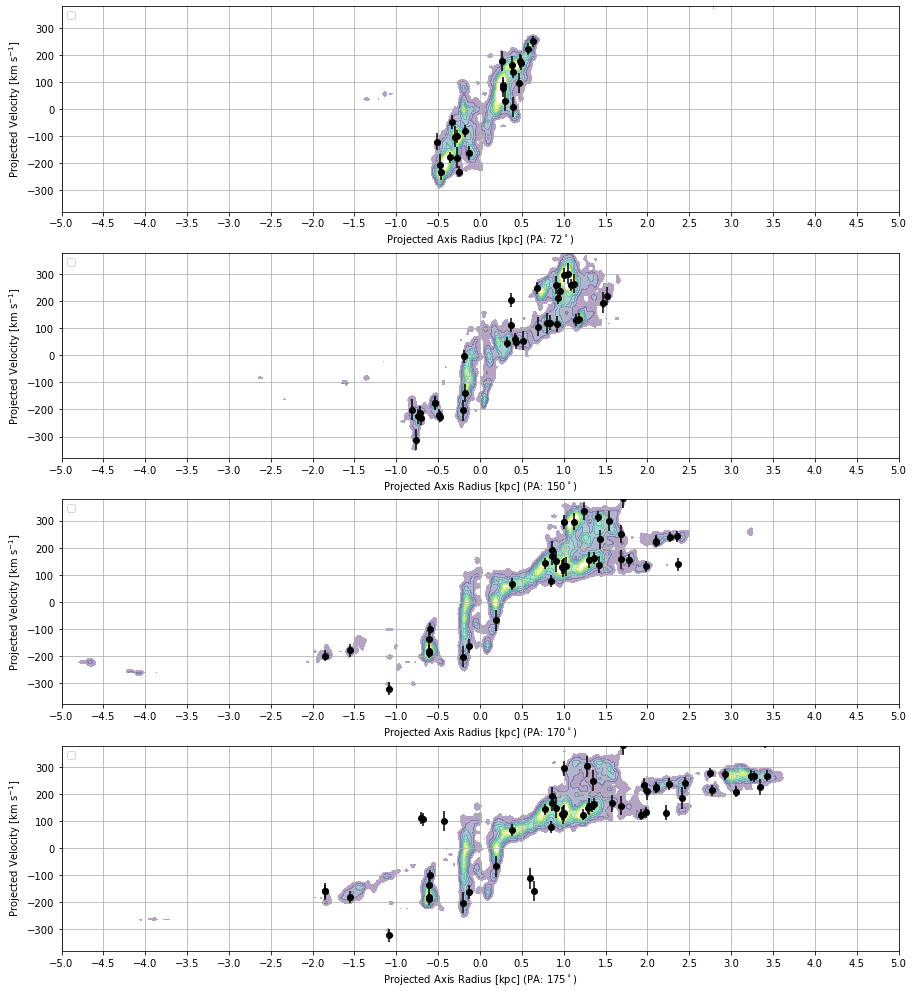

In [220]:
cube_total=CO21_total
slit=0.2
papvds=[72,150,170,175]
#papvds=[150,160]
ithick = int(round(slit/cube_total.attrs['dx']))
ixc = round(cube_total.dims['x']/2)
y=cube_total.y.data
v=cube_total.v.data
Npas=len(papvds)
lwd=3
lwd_n=1
alpha=0.1
levels=np.arange(2,10,1)
xlim=[-5,5]
vlim=[-380,380]
figsize=(20,10)
dxticks=0.5
dvticks=100
        
figsize=(15*(xlim[1]-xlim[0])/10,2.*Npas*(vlim[1]-vlim[0])/350) #if figsize == 'auto' else figsize
fig,ax=plt.subplots(nrows=Npas,figsize=figsize)#(20,6*len(papvds)))
for j,papvd in enumerate(papvds):
    rotcube=ndimage.interpolation.rotate(cube_total['cube'].fillna(0).data,papvd, axes=(1, 2), reshape=False)
    cubeslice = np.nansum(rotcube[:,:,ixc-ithick:ixc+ithick],axis=2)
    rotmadmap=ndimage.interpolation.rotate(cube_total['madcube'].fillna(0).data, papvd, axes=(1, 2), reshape=False)
    pvdmadmap=np.nansum(rotmadmap[:,:,ixc-ithick:ixc+ithick],axis=2)
    #pvdmadmap=np.sqrt(np.nansum(rotmadmap[:,:,ixc-ithick:ixc+ithick]**2,axis=2))
    pvd_cube=cubeslice/pvdmadmap;  #pvdlvs[0]
    pvd_cube=np.where(pvd_cube>=0,pvd_cube,np.nan)
    ax[j].contourf(y,v,pvd_cube,levels=levels,alpha=0.4,cmap='viridis')
    phi=np.radians(papvd+90)
    cospa=np.cos(phi)
    sinpa=np.sin(phi)
    tanpa=np.tan(phi)
    
    # Yslit_l=slit/(2*cospa)+Xcloud*tanpa
    # Yslit_u=-slit/(2*cospa)+Xcloud*tanpa

    # XX_s=Xcloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # YY_s=Ycloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # VV_s=Vcloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # AA_s=Acloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # Sv=Svcloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # #F_s=F[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]

    # PHI_s=np.arctan2(YY_s,XX_s)
    # RR_s=np.sqrt(XX_s**2+YY_s**2)

    # ax[j].errorbar(RR_s*np.sign(-np.cos(PHI_s)),VV_s,yerr=Sv,fmt='o',color='black')


    Yslit_l3=slit/(2*cospa)+X3d*tanpa
    Yslit_u3=-slit/(2*cospa)+X3d*tanpa

    XX_s=X3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    YY_s=Y3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    VV_s=V3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    Sv=Sv3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    #F_s=F[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]

    PHI_s=np.arctan2(YY_s,XX_s)
    RR_s=np.sqrt(XX_s**2+YY_s**2)

    ax[j].errorbar(RR_s*np.sign(-np.cos(PHI_s)),VV_s,yerr=Sv,fmt='o',color='black')

    ax[j].xaxis.set_ticks(np.arange(-8,8+dxticks,dxticks))
    ax[j].yaxis.set_ticks(np.arange(-600,600,dvticks))
    ax[j].set(xlim=xlim,ylim=vlim,xlabel=r'Projected Axis Radius [kpc] (PA: ${}^\circ$)'.format(papvd),ylabel=r'Projected Velocity [km s$^{-1}$]')
    ax[j].grid(True,which='both')
    ax[j].legend(loc=2)

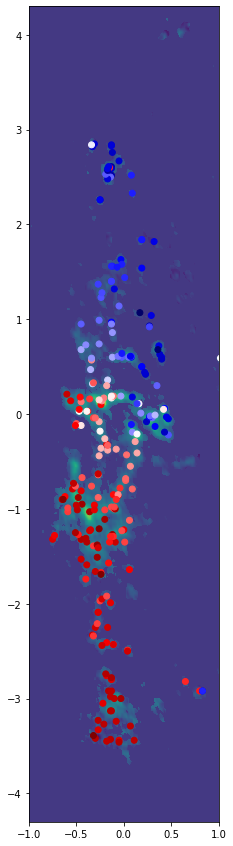

In [216]:
oo=(Xcloud>-0.13)&(Xcloud<0.19)&(Ycloud> -0.04)&(Ycloud<0.28)
# X3d=np.array([0.09,0.16,-0.13,0.14,0.18,-0.03,-0.11])
# Y3d=np.array([0.18,0.11,0.17,0.11,0.01,0.19,0.19])
# V3d=np.array([-203,-3,12,-138,-81,-68,95])
# a3d=np.array([186,216,265,505,268,400,314])
# b3d=np.array([-8.5,-192,-106,541,212,70,-252])
# c3d=np.array([605,160,534,300,500,613,328])
# s3d=np.array([40,25,32,33,22,39,32])
# A3d=np.array([12,4,21,8,9,23,4])
from scipy.optimize import fsolve,least_squares,minimize

def equations(p,a,b,c):
    sx, sy,t = p
    return np.array([a-np.cos(t)**2/sx**2-np.sin(t)**2/sy**2,b-np.sin(2*t)/sx**2-np.sin(2*t)/sy**2,c-np.sin(t)**2/sx**2-np.cos(t)**2/sy**2])
Sx3d=np.array([])
Sy3d=np.array([])
T3d=np.array([])

for a,b,c in zip(a3d,b3d,c3d):
    # sx, sy , t  =  fsolve(equations, (1, 1,1),args=(a,b,c))
    res=least_squares(equations, x0=[0.1, 0.1,1], args=(a,b,c))#,bounds=[[0,1],[0,1],[0,np.pi]] )
    sx, sy , t  = res.x 
    Sx3d=np.append(Sx3d,sx)
    Sy3d=np.append(Sy3d,sy)
    T3d=np.append(T3d,t)
Sx3d=np.abs(Sx3d)
Sy3d=np.abs(Sy3d)
T3d=np.degrees(T3d)
from matplotlib.patches import Ellipse
fig,ax=plt.subplots(1,1,figsize=(15,15))
ax.pcolormesh(CO21.x,CO21.y,np.nansum(CO21['cube'],axis=0),shading='auto')
ax.set(aspect=1,xlim=[-1,1],ylim=[-4.3,4.3])
# norm = mpl.colors.Normalize(vmin=-350, vmax=350)
# smap = mpl.cm.ScalarMappable(norm=None, cmap='seismic')
# CdV=smap.to_rgba(V3d)

norm = mpl.colors.Normalize(vmin=0, vmax=35)
smap = mpl.cm.ScalarMappable(norm=None, cmap='magma')
CdV=smap.to_rgba(A3d)
ax.scatter(X3d,Y3d,c=V3d,vmin=-350,vmax=350,cmap='seismic')
# for x3d,y3d,sx3d,sy3d,t3d,cdv in zip(X3d,Y3d,Sx3d,Sy3d,T3d,CdV):
#     el=Ellipse((x3d,y3d),2*sx3d,2*sy3d,angle=t3d,color=cdv,alpha=0.5)
#     ax.add_patch(el)

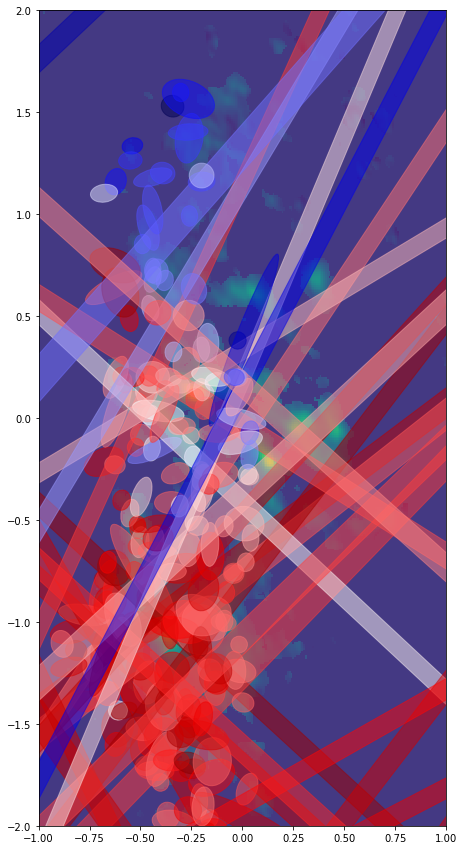

In [179]:
Sx3d=np.array([])
Sy3d=np.array([])
T3d=np.array([])
for a,b,c in zip(acloud,bcloud,ccloud):
    # sx, sy , t  =  fsolve(equations, (1, 1,1),args=(a,b,c))
    res=least_squares(equations, x0=[0.1, 0.1,1], args=(a,b,c))#,bounds=[[0,1],[0,1],[0,np.pi]] )
    sx, sy , t  = res.x 
    Sx3d=np.append(Sx3d,sx)
    Sy3d=np.append(Sy3d,sy)
    T3d=np.append(T3d,t)
Sx3d=np.abs(Sx3d)
Sy3d=np.abs(Sy3d)
T3d=np.degrees(T3d)

fig,ax=plt.subplots(1,1,figsize=(15,15))
ax.pcolormesh(CO21.x,CO21.y,np.nansum(CO21['cube'],axis=0),shading='auto')
ax.set(aspect=1,xlim=[-1,1],ylim=[-2,2])
# norm = mpl.colors.Normalize(vmin=-350, vmax=350)
# smap = mpl.cm.ScalarMappable(norm=None, cmap='seismic')
# CdV=smap.to_rgba(V3d)

norm = mpl.colors.Normalize(vmin=-350, vmax=350)
smap = mpl.cm.ScalarMappable(norm=None, cmap='seismic')
CdV=smap.to_rgba(Vcloud)

for x3d,y3d,sx3d,sy3d,t3d,cdv in zip(Xcloud,Ycloud,Sx3d,Sy3d,T3d,CdV):
    el=Ellipse((x3d,y3d),2*sx3d,2*sy3d,angle=t3d,color=cdv,alpha=0.5)
    ax.add_patch(el)

In [203]:
import sympy as sm

In [208]:
aas, bs, cs,ts,sxs,sys = sm.symbols('a, b, c,t,sx,sy',real=True, positive=True)


In [212]:
eq=[aas-sm.cos(ts)**2/sxs**2-sm.sin(ts)**2/sys**2,bs-sm.sin(2*ts)/sxs**2-sm.sin(2*ts)/sys**2,cs-sm.sin(ts)**2/sxs**2-sm.cos(ts)**2/sys**2]

In [ ]:

sm.solve(eq,(ts,sxs,sys),minimal=True)

In [240]:
sys.path.insert(1, '../scripts/fitters')
import p_six
import model_creation

In [252]:
p_six.make_disks

<function p_six.make_disks(params, R_disks, dR_disks, dic)>

In [250]:
reload(model_creation)
six_dic=model_creation.prepare_params(p_six.dic)
R_d = np.arange(0.01,4.4,0.08)
dR_d=0.08/2
bounds=six_dic['bounds']#np.array(bounds)
params0=six_dic['params0']

Parameter logM has index 12
Parameter a has index 13
Parameter logMvir has index 14
PA parameters have indexes [0:6]
Inc parameters have indexes [6:12]
Total Parameters we are going to fit 15


In [264]:
def get_RES(X,Y,V,R,PHI,params,disks_f,R_d,dR_d,dic,epsilon_v=30,dV0=500,delta_v=30,da=3):
    #Phi_d,I_d,Vc_d,tani2s,vsinis=make_disks(params,Rpa,Ri,R_d,params_dic)
    R_d,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    flag=[False]*X.shape[0]
    Z=np.array([np.nan]*X.shape[0])
    dV=np.array([dV0]*X.shape[0])

    #phis=np.linspace(0,2*np.pi,1000)
    #vvv=np.linspace(-400,400,500)
    #rms=cube.attrs['rms']
    for k,(x,y,v,r,phi) in enumerate(zip(X,Y,V,R,PHI)):
        dvi_min=dV0
        for m,(rd,vcd,i_d,phi_d,tani2,vsini,tani12,tani22) in enumerate(zip(R_d,Vc_d,I_d,Phi_d,tani2s,vsinis,tanI12,tanI22)):

            rell1=(rd-dR_d)/(1+tani12*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i1,R-dR)
            rell2=(rd+dR_d)/(1+tani22*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i2,R+dR)

            if (r>=rell1) and (r<=rell2):

                rell=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5# center ellipse of the ring
                drell=r-rell #distance from the center of the ring
                #r_t=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5 #corrected distance of the cloud assigned to the disk. if not corrected then due to thickness of the ring z wil be wrong
                zs=np.sign(-math.tan(i_d)*(x*math.cos(phi_d)+y*math.sin(phi_d))) #sign of the z position
                zz=math.sqrt((rd+drell)**2-r**2)*zs # z position of the cloud if it is assigned on this disk. 

                Vd_sky=vsini*np.sin(phi-phi_d)/(1 +tani2*np.cos(phi-phi_d)**2)**0.5
                #Vs=np.sort(np.abs(Vd_sky-v))
                dvi=np.abs(Vd_sky-v)
                if dvi<dvi_min:
                    dvi_min=dvi
                    dV[k]=Vd_sky-v
                    Z[k]=zz

                flag[k]=flag[k] | (dvi<epsilon_v)
                #dV[k]=np.nanmin([dV[k],dv],axis=0)
                #idv=np.nanargmin([np.abs(dV[k]),np.abs(dv)],axis=0)
                #dV[k]=np.array([[dV[k][j],dv[j]][idv[j]] for j in range(len(v))])#np.nanmin([dV[k],dv],axis=0)
                #Z[k]=np.array([[Z[k][j],zz][idv[j]] for j in range(len(v))])
    return flag,Z,dV

In [280]:
def likelihood_V(params,X,Y,V,R,PHI,disks_f,R_d,dR_d,dic,dV0=500,delta_v=30):
    #Phi_d,I_d,Vc_d,tani2s,vsinis=make_disks(params,Rpa,Ri,R_d,params_dic)
    R_d,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    #flag=[False]*X.shape[0]
    #Z=np.array([np.nan]*X.shape[0])
    dV=np.array([dV0]*X.shape[0])

    #phis=np.linspace(0,2*np.pi,1000)
    #vvv=np.linspace(-400,400,500)
    #rms=cube.attrs['rms']
    for k,(x,y,v,r,phi) in enumerate(zip(X,Y,V,R,PHI)):
        dvi_min=dV0
        for m,(rd,vcd,i_d,phi_d,tani2,vsini,tani12,tani22) in enumerate(zip(R_d,Vc_d,I_d,Phi_d,tani2s,vsinis,tanI12,tanI22)):

            rell1=(rd-dR_d)/(1+tani12*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i1,R-dR)
            rell2=(rd+dR_d)/(1+tani22*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i2,R+dR)

            if (r>=rell1) and (r<=rell2):

                # rell=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5# center ellipse of the ring
                # drell=r-rell #distance from the center of the ring
                # #r_t=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5 #corrected distance of the cloud assigned to the disk. if not corrected then due to thickness of the ring z wil be wrong
                # zs=np.sign(-math.tan(i_d)*(x*math.cos(phi_d)+y*math.sin(phi_d))) #sign of the z position
                # zz=math.sqrt((rd+drell)**2-r**2)*zs # z position of the cloud if it is assigned on this disk. 

                Vd_sky=vsini*np.sin(phi-phi_d)/(1 +tani2*np.cos(phi-phi_d)**2)**0.5
                #Vs=np.sort(np.abs(Vd_sky-v))
                dvi=np.abs(Vd_sky-v)
                if dvi<dvi_min:
                    dvi_min=dvi
                    dV[k]=Vd_sky-v
                    #Z[k]=zz

                #flag[k]=flag[k] | (dvi<epsilon_v)
                #dV[k]=np.nanmin([dV[k],dv],axis=0)
                #idv=np.nanargmin([np.abs(dV[k]),np.abs(dv)],axis=0)
                #dV[k]=np.array([[dV[k][j],dv[j]][idv[j]] for j in range(len(v))])#np.nanmin([dV[k],dv],axis=0)
                #Z[k]=np.array([[Z[k][j],zz][idv[j]] for j in range(len(v))])
    return 0.5*np.sum(dV**2)/delta_v**2

In [265]:
flag,Z,dV=get_RES(X3d,Y3d,V3d,R3d,PHI3d,params0,p_six.make_disks,R_d,dR_d,six_dic,epsilon_v=30,dV0=500,delta_v=30,da=3)

../scripts/fitters/p_six.py:72: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


In [281]:
likelihood_V(params0,X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,dV0=500,delta_v=30)

../scripts/fitters/p_six.py:72: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


4033.5616666666665

In [283]:
sol=differential_evolution(likelihood_V,bounds,tol=0.1,args=(X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,500,30))

../scripts/fitters/p_six.py:72: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


In [269]:
def plot_residuals(X,Y,A,dV,params,R_d,dR_d,disks_f,dic,xlim=[-1.4,1.4],ylim=[-4,4],dvmin=0,dvmax=1000):
    mosaic= [['dV','A_res']]
    gridspec_kw={'width_ratios': [1,1],'height_ratios': [1]}
    fig = plt.figure(constrained_layout=False,figsize=(16,11))
    ax = fig.subplot_mosaic(mosaic,gridspec_kw=gridspec_kw)
    divider = make_axes_locatable(ax['dV'])
    caxdV = divider.append_axes("top", size="2.5%", pad=0.05)
    Vlims=(np.abs(dV)>dvmin)&(np.abs(dV)<dvmax)
    cm=ax['dV'].scatter(X[Vlims],Y[Vlims],marker='.',c=dV[Vlims],vmin=-350,vmax=350,cmap='seismic',alpha=0.5)
    ax['dV'].set(aspect=1,xlabel='x',ylabel='y',xlim=xlim,ylim=ylim)
    plt.colorbar(cm,cax=caxdV,orientation='horizontal',fraction=0.046,pad=0.04).ax.tick_params(labelsize=9)
    caxdV.xaxis.set_ticks_position("top")
    #
    divider = make_axes_locatable(ax['A_res'])
    caxA = divider.append_axes("top", size="2.5%", pad=0.05)
    cmA=ax['A_res'].scatter(X[Vlims],Y[Vlims],marker='.',c=A[Vlims],norm=LogNorm(),cmap='magma',alpha=0.3)
    plt.colorbar(cmA,cax=caxA,orientation='horizontal',fraction=0.046,pad=0.04).ax.tick_params(labelsize=9)
    caxA.xaxis.set_ticks_position("top")
    
    phis=np.linspace(0,2*np.pi,800)
    R_d2,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    for m,(rd,vcd,i_d,phi_d) in enumerate(zip(R_d2,Vc_d,I_d,Phi_d)):
        Rd_sky=rd/(1+np.tan(i_d)**2*np.cos(phis-phi_d)**2)**0.5
        xd=Rd_sky*np.cos(phis)
        yd=Rd_sky*np.sin(phis)
        ax['A_res'].plot(xd,yd,alpha=0.25)

    ax['A_res'].set(aspect=1,xlabel='x',ylabel='y',xlim=xlim,ylim=ylim)

../scripts/fitters/p_six.py:72: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


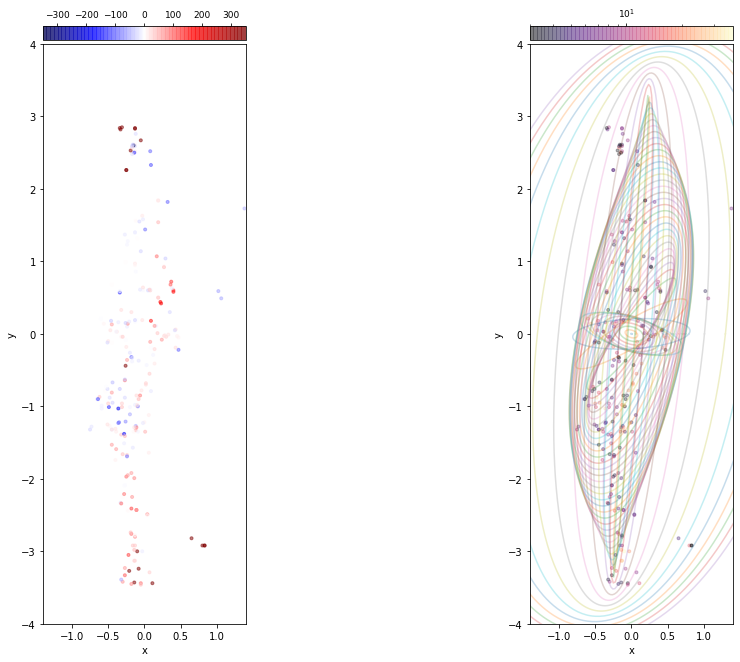

In [270]:
plot_residuals(X3d,Y3d,A3d,dV,params0,R_d,dR_d,p_six.make_disks,six_dic,xlim=[-1.4,1.4],ylim=[-4,4],dvmin=0,dvmax=1000)

In [273]:
np.sum(dV**2/30**2)

8067.123333333333